# working notebook

### Utility Functions:
- load_bitcoin_edge_data(filename)
- user_activity_dataframe(bitcoin_df) <-- uses user_stats(bitcoin_df)
- build_graph(bitcoin_df, user_lst=[], rating_type='all', maxdate='2016-01-24')
#### visualization functions:
- plot_timeline(bitcoin_df, title)
- add_user_to_graph(existing_graph, new_user, bitcoin_df)

### EDA Learnings:
alpha network does not have time level timestamp so cannot do velocity or bot analysis
or sort chronologically within a day

### Interesting Fraud Examples:
otc_user = '2680'

In [3]:
import pandas as pd
import numpy as np
import datetime
import networkx as nx
import nxpd

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../src')
import helpers as h
import visualizations as v
import model as m

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
import time

In [2]:
# Load and preprocess data
otc_df = h.load_bitcoin_edge_data('../data/soc-sign-bitcoinotc.csv.gz')
alpha_df = h.load_bitcoin_edge_data('../data/soc-sign-bitcoinalpha.csv.gz')
alpha_users = h.user_activity_dataframe(alpha_df)
otc_users = h.user_activity_dataframe(otc_df)

In [1]:
# Example User Collusion Fraud
# df_otc = pd.read_csv('../data/df_features_otc.csv')
# df_otc[df_otc['ratee']==4986]

In [3]:
# Load graph objects
_ , alpha_G = h.build_graph(alpha_df)
_ , alpha_pos_G = h.build_graph(alpha_df, rating_type='pos')
_ , otc_G = h.build_graph(otc_df)
_ , otc_pos_G = h.build_graph(otc_df, rating_type='pos')

# Prediction Visualizations

In [4]:
df = pd.read_csv("../data/alpha_with_ratee_stats.csv")

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
X = df.copy()
X = X.drop(['rater', 'ratee', 'rating','date', 'color', 'penwidth', 'binomial_rating'], axis=1)
y = X.pop('class')


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, shuffle=True,
                                                    random_state=123)

RF = RandomForestClassifier(n_jobs=-1, random_state=123)
RF.fit(X_train, y_train)
y_preds = RF.predict(X_test)
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)

# print(X_test[(y_preds==0) & (X_test['num_neg_received']>0)].head(10))
print(recall)
print(precision)
RF.feature_importances_
 

0.5911458333333334
0.8107142857142857


array([0.0772982 , 0.07133731, 0.09756422, 0.11934134, 0.2249306 ,
       0.16253055, 0.12591187, 0.12108592])

Text(0.5,1,'Random Forest feature importance')

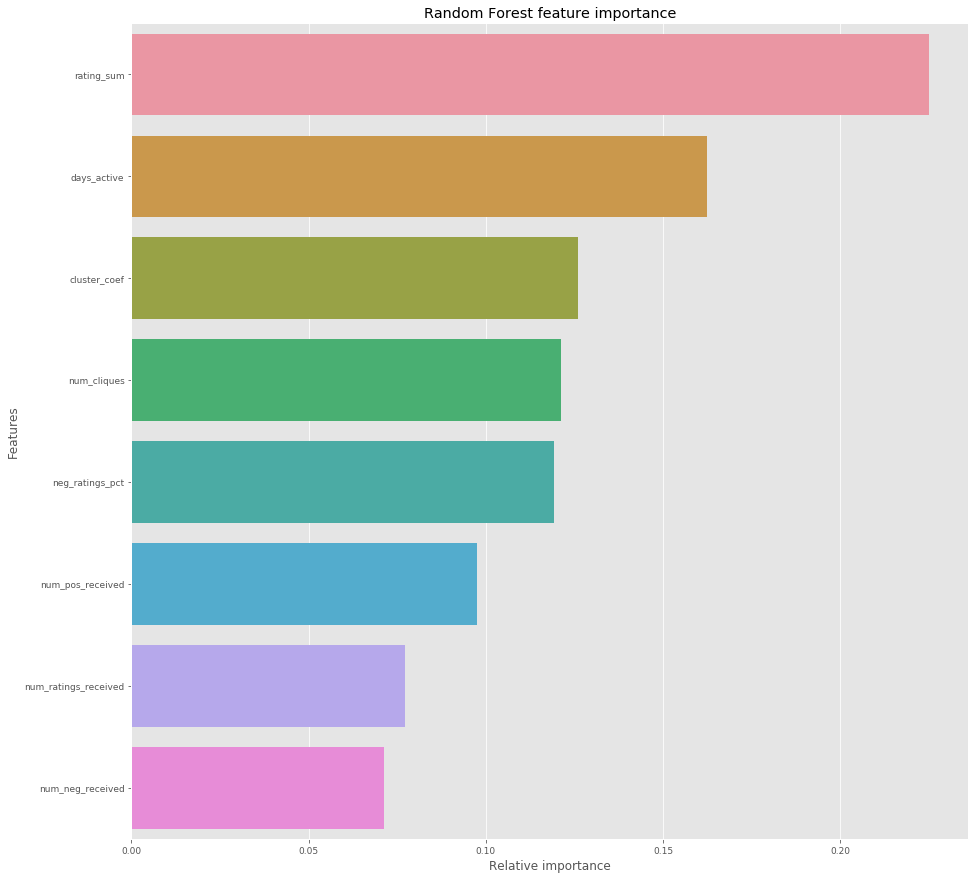

In [8]:
import seaborn as sns
fig = plt.figure(figsize=(15,15))

name = "Random Forest"
indices = np.argsort(RF.feature_importances_)[::-1][:40]
ax1 = sns.barplot(y=X_train.columns[indices][:40],x = RF.feature_importances_[indices][:40] , orient='h')
ax1.set_xlabel("Relative importance",fontsize=12)
ax1.set_ylabel("Features",fontsize=12)
ax1.tick_params(labelsize=9)
ax1.set_title(name + " feature importance")